In [1]:
#### IMPORTS  ####
from pathlib import Path
from typing import Tuple, List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tqdm
import random
import datetime
import pathlib
import pytz
import glob
import re
from google.colab import drive
from torch.autograd import Variable
import seaborn as sns
import os
import shutil
import copy
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import scipy.io
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
HEIGHT = 30
WIDTH = 34

In [3]:
def matlab_to_datetime(mtime):
  # from matlab datenum to python datetime and round to the nearest minute
  ptime = [datetime.fromordinal(int(mtime[i])) + timedelta(days=mtime[i]%1) - timedelta(days = 366) for i in range(0,len(mtime))]
  ptimernd = [datetime(ptime[i].year, ptime[i].month, ptime[i].day, ptime[i].hour, ptime[i].minute)+ timedelta(minutes=(ptime[i].second>30)) for i in range(0,len(mtime))]
  ptime = np.asarray(ptimernd)
  return ptime

def read_matlab_event_file(file_name):
  # read .mat file of event struct
  data = scipy.io.loadmat(file_name=file_name, squeeze_me=True, struct_as_record=True)
  data = data['event_struc']
  event_num = data.shape[0]
  print(['Number of events: ',event_num])
  ls = []
  for en in range(0,event_num):
    peak_time = matlab_to_datetime([data[en][0]])[0]
    event_start = matlab_to_datetime([data[en][1]])[0]
    event_end = matlab_to_datetime([data[en][2]])[0]
    duration_h = data[en][3]
    flow_times = matlab_to_datetime(data[en][4])
    flow_vals = data[en][5]
    radar_rain = data[en][6]
    radar_times = matlab_to_datetime(data[en][7])
    flow_vals_interp = np.interp(data[en][7], data[en][4], data[en][5]) # TODO: 1) flow time goes beyond radar time and should be added. 2) peak is truncated due to the interpolation
    ls.append([peak_time,event_start,event_end,duration_h,flow_times, flow_vals, radar_rain, radar_times, flow_vals_interp])

  pd_events = pd.DataFrame(data=ls, columns = ['peak_time','start','end','duration_h','flow_times', 'flow_vals', 'radar_rain', 'radar_times', 'flow_vals_interp'])

  return pd_events

def reshape_data(x: np.ndarray, y: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
  """
  Reshape matrix data into sample shape for LSTM training.
  :param x: Matrix containing input features column wise and time steps row wise
  :param y: Matrix containing the output feature.
  :param seq_length: Length of look back days for one day of prediction 
  :return: Two np.ndarrays, the first of shape (samples, length of sequence,
    number of features), containing the input data for the LSTM. The second
    of shape (samples, 1) containing the expected output for each input
    sample.
  """
  num_samples, num_features = x.shape
  x_new = np.zeros((num_samples - seq_length + 1, seq_length, num_features))
  y_new = np.zeros((num_samples - seq_length + 1, 1))
  for i in range(0, x_new.shape[0]):
    x_new[i, :, :num_features] = x[i:i + seq_length, :]
    y_new[i, :] = y[i + seq_length - 1, 0]
  return x_new, y_new

In [4]:
PATH_ROOT = "drive/MyDrive/Efrat/"# Change only here the path
#PATH_ROOT = "drive/MyDrive/RonenRojasEfratMorin/Code/" # Change only here the path
file_name=PATH_ROOT+'/Data/Israel/event_struc.mat'
pd_events = read_matlab_event_file(file_name)

['Number of events: ', 22]


In [5]:
class Israel(Dataset):
  """
  Torch Dataset for basic use of data from the data set. 
  This data set provides meteorological observations and discharge of a given basin from the Israel data set.
  """
  def __init__(self, df_all_data: pd.DataFrame, event_list: List, seq_length: int, period: str=None, min_value: np.array=None, max_value: np.array=None, lead=0, mean_y=None, std_y=None):
    """Initialize Dataset containing the data of a single basin.
    :param seq_length: Length of the time window of meteorological input provided for one time step of prediction.
    :param period: (optional) One of ['train', 'eval']. None loads the entire time series.
    :param dates: (optional) List ofthe start and end date of the discharge period that is used.
    """
    self.seq_length = seq_length
    self.event_list = event_list
    self.period = period
    self.min_value = min_value
    self.max_value = max_value
    self.mean_y = mean_y
    self.std_y = std_y
    self.lead = lead
    self.num_features = None
    self.event_length_list = []
    # load data
    self.x , self.y= self._load_data(df_all_data)
    # store number of samples as class attribute
    self.num_samples = self.x.shape[0]
    # store number of features as class attribute

  def __len__(self):
    return self.num_samples

  def __getitem__(self, idx: int):
    return self.x[idx], self.y[idx]

  def _load_data(self, df_all_data):
    """Load input and output data from dataframe.    """
    first_event = True
    for event_idx in self.event_list:
      event_size = len(df_all_data['flow_vals_interp'][event_idx])
      x_event, y_event = self._load_event(df_all_data['radar_rain'][event_idx], df_all_data['flow_vals_interp'][event_idx], event_size)
      print(f"Event {event_idx}, x.shape = {x_event.shape}, y.shape = {y_event.shape}")
      self.event_length_list.append(len(y_event))
      if first_event:
        x, y = x_event, y_event
        first_event = False
      else:
        x = np.concatenate([x, x_event], axis=0)
        y = np.concatenate([y, y_event])
    if self.period == 'train':
      self.min_value  = x.min()
      self.max_value = x.max()
    # Normalizing the rain data  
    x -= self.min_value
    x /= (self.max_value - self.min_value)
    
    if self.period == "train":
      # normalize discharge
      self.mean_y = y.mean()
      self.std_y = y.std()
      y = self._local_normalization(y, variable='output')
    print("Data set for {0} for Events: {1}".format(self.period, self.event_list))
    print("Data size for LSTM should be: (num_samples, sequence_len, num_features) = {0}".format(x.shape))    
    # convert arrays to torch tensors
    x = torch.from_numpy(x.astype(np.float32))
    y = torch.from_numpy(y.astype(np.float32))
    return x, y
  
  def _load_event(self, event_data, event_label, event_size):
    
    # Clean nan 
    event_data[np.isnan(event_data)] = 0.0
    # Reshahpe data to 1D
    x = np.reshape(event_data, (HEIGHT*WIDTH, event_data.shape[2])).T
    return reshape_data(x[:(event_size - self.lead),:], np.matrix(event_label[self.lead:]).T, self.seq_length)
  
  def _local_normalization(self, feature: np.ndarray, variable: str) -> np.ndarray:
    """Normalize input/output features with local mean/std."""
    if variable == 'output':
      feature = (feature - self.mean_y) /self.std_y
    else:
      raise RuntimeError(f"Unknown variable type {variable}")
    return feature
  
  def local_rescale(self, feature: np.ndarray, variable: str) -> np.ndarray:
    """Rescale output features with local mean/std.
      :param feature: Numpy array containing the feature(s) as matrix.
      param variable: Either 'inputs' or 'output' showing which feature will
      be normalized
    :return: array containing the normalized feature
    """
    if variable == 'output':
      feature = feature * self.std_y + self.mean_y
    else:
      raise RuntimeError(f"Unknown variable type {variable}")
    return feature

  def get_min(self):
    return self.min_value

  def get_max(self):
    return self.max_value

  def get_mean_y(self):
    return self.mean_y

  def get_std_y(self):
    return self.std_y
    
  def get_num_features(self):
    return self.num_features





In [6]:
class DNN(nn.Module):
  def __init__(self, input_size: int, num_hidden_layers: int, num_hidden_units: int, dropout_rate: float=0.0):
    super(DNN, self).__init__()
    self.input_size = input_size
    self.num_hidden_layers = num_hidden_layers
    self.num_hidden_units = num_hidden_units
    self.dropout_rate = dropout_rate    
    self.input_layer = nn.Linear(self.input_size, self.num_hidden_units)
    self.hidden_layer = nn.Linear(self.num_hidden_units, self.num_hidden_units)
    self.output_layer = nn.Linear(self.num_hidden_units, 1)
    self.dropout = nn.Dropout(p=self.dropout_rate)

  def forward(self, x):
    batch_size, timesteps, ts_size = x.size()
    x = x.view(batch_size, timesteps*ts_size)
    x = self.input_layer(x)
    for i in range(0,self.num_hidden_layers):
      x = self.hidden_layer(F.relu(self.hidden_layer(x)))
    pred = self.dropout(self.output_layer(x))
    return pred


class CNN(nn.Module):
  def __init__(self, num_channels: int, input_size: int):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(num_channels, 2, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(2, 4, 5)
    self.fc1 = nn.Linear(80, input_size)
    self.dropout1 = nn.Dropout()

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 80)
    x = self.fc1(x)
    return x


In [ ]:
net = CNN(1, 15)
x =torch.rand(1, 1 , HEIGHT, WIDTH)
y =net(x)
y.size()
4*4*5

torch.Size([1, 4, 4, 5])


80

In [7]:
class CNNLSTM(nn.Module):
#  def __init__(self, input_size: int , hidden_size: int, num_channels: int, dropout_rate: float=0.0, num_layers: int=1, num_attributes: int=1):
  def __init__(self, input_size: int , hidden_size: int, num_channels: int, dropout_rate: float=0.0, num_layers: int=1, num_attributes: int=0):
    """Initialize model    
       :param hidden_size: Number of hidden units/LSTM cells
      :param dropout_rate: Dropout rate of the last fully connected layer. Default 0.0
    """
    super(CNNLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.dropout_rate = dropout_rate    
    self.num_channels = num_channels
    self.cnn = CNN(num_channels=num_channels, input_size=(input_size - num_attributes))
    # create required layer
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, num_layers=num_layers, bias=True, batch_first=True)
    self.dropout = nn.Dropout(p=self.dropout_rate)
    self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)
        
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward pass through the Network.  
      param x: Tensor of shape [batch size, seq length, num features] containing the input data for the LSTM network.
      :return: Tensor containing the network predictions
    """
    #print(x.size())
    batch_size, timesteps, _ = x.size()
    # cropping the "image" part of the input
    image = x[:,:, :self.num_channels*HEIGHT*WIDTH]
    image= image.view(batch_size, timesteps, self.num_channels, HEIGHT*WIDTH)
    image= image.view(batch_size, timesteps, self.num_channels, HEIGHT, WIDTH)
    c_in = image.view(batch_size * timesteps, self.num_channels, HEIGHT, WIDTH)
    # CNN part
    c_out = self.cnn(c_in)
    # CNN output should in the size of input size - atrributes_size
    cnn_out = c_out.view(batch_size, timesteps, -1)
    # cropping the "image" part of the input 
    a_in = x[:,:, self.num_channels*HEIGHT*WIDTH:]
    r_in = torch.cat((cnn_out, a_in), 2)
    output, (h_n, c_n) = self.lstm(r_in)
    # perform prediction only at the end of the input sequence
    pred = self.fc(self.dropout(h_n[-1,:,:]))
    return pred


In [8]:
def train_epoch(model, optimizer, loader, loss_func, epoch):
    """Train model for a single epoch.

    :param model: A torch.nn.Module implementing the LSTM model
    :param optimizer: One of PyTorchs optimizer classes.
    :param loader: A PyTorch DataLoader, providing the trainings
        data in mini batches.
    :param loss_func: The loss function to minimize.
    :param epoch: The current epoch (int) used for the progress bar
    """
    # set model to train mode (important for dropout)
    model.train()
    pbar = tqdm.notebook.tqdm(loader)
    pbar.set_description(f"Epoch {epoch}")
    #request mini-batch of data from the loader
    for xs, ys in pbar:
        # delete previously stored gradients from the model
        optimizer.zero_grad()
        # push data to GPU (if available)
        xs, ys = xs.to(device), ys.to(device)
        # get model predictions
        y_hat = model(xs)
        # calculate loss
        loss = loss_func(y_hat, ys)
        # calculate gradients
        loss.backward()
        # update the weights
        optimizer.step()
        #write current loss in the progress bar
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        
def eval_model(model, loader) -> Tuple[torch.Tensor, torch.Tensor]:
    """Evaluate the model.

    :param model: A torch.nn.Module implementing the LSTM model
    :param loader: A PyTorch DataLoader, providing the data.
    
    :return: Two torch Tensors, containing the observations and 
        model predictions
    """
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.to(device)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)
            
    return torch.cat(obs), torch.cat(preds)

def calc_mse(obs: np.array, sim: np.array) -> float:
  return np.mean((obs - sim) ** 2)

def calc_nse(obs: np.array, sim: np.array) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    # COMMENT FROM EFRAT TO RONEN: NEGATIVE VALUES ARE FINE! I COMMENTED THE TWO LINES BELOW
    # sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    # obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val
  
def calc_persist_nse(obs: np.array, sim: np.array, lead ) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    # COMMENT FROM EFRAT TO RONEN: NEGATIVE VALUES ARE FINE! I COMMENTED THE TWO LINES BELOW
    # sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    # obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    # the reference is the last observed, instead of the mean
    sim = sim[lead:]
    obs = obs[lead:]
    ref = obs[:-lead]

    denominator = np.sum((obs - ref) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    persist_nse_val = 1 - numerator / denominator

    return persist_nse_val

def calc_bias(obs: np.array, sim: np.array) -> float:
    """ Calculate bias

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    bias_95 = None
    if (np.percentile(obs, 95)!=0):
      bias_95 = (np.percentile(sim, 95) - np.percentile(obs, 95))/np.percentile(obs, 95)*100
    bias_5 = None
    if (np.percentile(obs, 5)!=0):
      bias_5 = (np.percentile(sim, 5) - np.percentile(obs, 5))/np.percentile(obs, 5)*100
    mean_bias = None
    if (np.nanmean(obs)!=0):
      mean_bias = (np.nanmean(sim) - np.nanmean(obs))/np.nanmean(obs)*100

    return bias_95, bias_5, mean_bias

def calc_maxdif(obs: np.array, sim: np.array) -> float:
    """ Calculate max difference in percent

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: maxdif value.
    """
    max_sim = np.nanmax(sim)
    max_obs = np.nanmax(obs)

    return (max_sim-max_obs)/max_obs*100

def calc_vol_qp(obs: np.array) -> float:
    """ Calculate volume [10^6 m^3] and peak discharge [m^3/s]

    :param obs: Array containing the observations
    :return: vol and qp values.
    """
    vol = np.nansum(obs)*3600*24/1E6 # translate from m^3/s in daily resolution to 10^6 m^3 TO CORRECT UNITS!
    qp = np.nanmax(obs)

    return vol, qp

In [9]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Set random seed for reproducibility
# manualSeed = 999
# #manualSeed = random.randint(1, 10000) # use if you want new results
# #print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)

#################################
###### Meta parameters ##########
#################################
hidden_size = 15 # Number of LSTM cells
dropout_rate = 0.0 # Dropout rate of the final fully connected Layer [0.0, 1.0]
#learning_rate = 2e-3 # Learning rate used to update the weights
learning_rate = 1e-3 # Learning rate used to update the weights
sequence_length = 30 # Length of the meteorological record provided to the network
num_layers = 1 # Number of LSTM cells
lead = 0 #1
cnn_outputsize = 20
num_hidden_layers = 3
num_hidden_units = 128

# ### Choose features ###
# use_perc = True
# use_t_max = False
# use_t_min = False
# idx_features= [use_perc, use_t_max, use_t_min]
# ### Choose basin ### 
# #basin_list = ['Mancherial', 'Perur' ,'Pathagudem','Polavaram', 'Tekra']
# basin_list = ['Tekra','Perur']

# ##############
# # Data set up#
# ##############
# CATCHMENT_DICT = create_catchment_dict(PATH_CATCHMENTS) 
INCLUDE_STATIC = False

# # Training data
# # start_date = (1967, 1, 1)
# # end_date = (1999, 12, 31)
# start_date = (2000, 1, 1)
# end_date = (2009, 12, 31)
# months_lst = [6,7,8,9,10]

print('Train dataset\n===============================')
#ds_train = IMDGodavari(all_data, basin_list=basin_list, seq_length=sequence_length, period="train", dates=[start_date, end_date], idx= idx_features, lead=lead)
ds_train  = Israel(pd_events, event_list=[0,1,2,3,4,5,6,7,8,9,10, 11 ,12 ,13, 14 ,15 ,16 ,17 , 18 , 19 ,20, 21], seq_length=sequence_length, period='train', lead=lead)
tr_loader = DataLoader(ds_train, batch_size=64, shuffle=True)

# # Test data. We use the feature min/max of the training period for normalization
# # start_date = (1995, 1, 1)
# # end_date = (1999, 12, 31)
# start_date = (2000, 1, 1)
# end_date = (2009, 12, 31)
print('\nTest dataset\n===============================')
#ds_test = IMDGodavari(all_data, basin_list, seq_length=sequence_length, period="eval", dates=[start_date, end_date], idx= idx_features, lead=lead, min_values=ds_train.get_min(), max_values=ds_train.get_max(), include_static=True)
ds_test  = Israel(pd_events, event_list=[14,15,16,17,18,19], seq_length=sequence_length, period='eval', 
                  min_value=ds_train.get_min(), max_value=ds_train.get_max(), lead=lead, 
                  mean_y= ds_train.mean_y, std_y= ds_train.std_y)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)

#########################
# Model, Optimizer, Loss#
#########################

# Here we create our model
#num_attributes = CATCHMENT_DICT['Tekra'].size
if INCLUDE_STATIC==False:
  num_attributes = 0
input_size = HEIGHT*WIDTH*sequence_length
model = CNNLSTM(input_size=cnn_outputsize, num_layers=num_layers, hidden_size=hidden_size, dropout_rate=dropout_rate, num_channels=1, num_attributes=0 ).to(device)
#model = DNN(input_size=input_size, num_hidden_layers=num_hidden_layers, num_hidden_units=num_hidden_units, dropout_rate=dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()



Train dataset
Event 0, x.shape = (262, 30, 1020), y.shape = (262, 1)
Event 1, x.shape = (262, 30, 1020), y.shape = (262, 1)
Event 2, x.shape = (222, 30, 1020), y.shape = (222, 1)
Event 3, x.shape = (262, 30, 1020), y.shape = (262, 1)
Event 4, x.shape = (262, 30, 1020), y.shape = (262, 1)
Event 5, x.shape = (262, 30, 1020), y.shape = (262, 1)
Event 6, x.shape = (406, 30, 1020), y.shape = (406, 1)
Event 7, x.shape = (125, 30, 1020), y.shape = (125, 1)
Event 8, x.shape = (406, 30, 1020), y.shape = (406, 1)
Event 9, x.shape = (262, 30, 1020), y.shape = (262, 1)
Event 10, x.shape = (406, 30, 1020), y.shape = (406, 1)
Event 11, x.shape = (51, 30, 1020), y.shape = (51, 1)
Event 12, x.shape = (371, 30, 1020), y.shape = (371, 1)
Event 13, x.shape = (262, 30, 1020), y.shape = (262, 1)
Event 14, x.shape = (406, 30, 1020), y.shape = (406, 1)
Event 15, x.shape = (262, 30, 1020), y.shape = (262, 1)
Event 16, x.shape = (195, 30, 1020), y.shape = (195, 1)
Event 17, x.shape = (248, 30, 1020), y.shape =

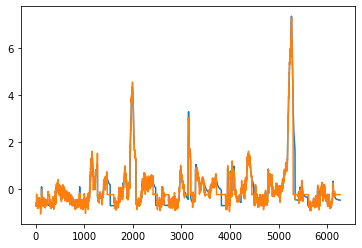

In [25]:
train_loader = DataLoader(ds_train, batch_size=2048, shuffle=False)
obs, preds = eval_model(model, train_loader)
plt.plot(ds_train.y)
plt.plot(preds.cpu().numpy())

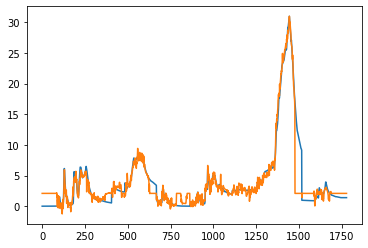

In [23]:
obs, preds = eval_model(model, test_loader)
preds = ds_test.local_rescale(preds.cpu().numpy(), variable='output')
plt.plot(ds_test.y)
plt.plot(preds)

In [29]:
n_epochs = 200 # Number of training epochs
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate/2)
# Creating the checkpoint folders
#datetime_israel = datetime.datetime.now(pytz.timezone('Israel'))
#path_train_ckpt = PATH_MODEL + datetime_israel.strftime("%Y_%m_%d-%H-%M-%S/") 
#pathlib.Path(path_train_ckpt).mkdir(parents=True, exist_ok=True)

for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader, loss_func, i+1)
    if (i+1) %  1 == 0:
      obs, preds = eval_model(model, test_loader)
      preds = ds_test.local_rescale(preds.cpu().numpy(), variable='output')
      nse = calc_nse(obs.numpy(), preds)
      mse = calc_mse(obs.numpy(), preds)
      tqdm.tqdm.write(f"Epoch: {i+1:d} Test NSE: {nse:.3f}, Test MSE: {mse:.3f}")
      #model_name = "epoch_{:d}_nse_{:.3f}.ckpt".format(i+1, nse)
#    torch.save(model, path_train_ckpt + model_name)
#    last_model_path = path_train_ckpt + model_name

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 1 Test NSE: 0.904, Test MSE: 2.987


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 2 Test NSE: 0.902, Test MSE: 3.030


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3 Test NSE: 0.905, Test MSE: 2.957


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 4 Test NSE: 0.904, Test MSE: 2.989


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 5 Test NSE: 0.904, Test MSE: 2.988


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 6 Test NSE: 0.904, Test MSE: 2.964


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 7 Test NSE: 0.902, Test MSE: 3.035


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 8 Test NSE: 0.901, Test MSE: 3.063


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 9 Test NSE: 0.905, Test MSE: 2.943


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 10 Test NSE: 0.904, Test MSE: 2.973


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 11 Test NSE: 0.905, Test MSE: 2.942


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 12 Test NSE: 0.903, Test MSE: 3.021


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 13 Test NSE: 0.903, Test MSE: 3.020


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 14 Test NSE: 0.905, Test MSE: 2.949


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 15 Test NSE: 0.900, Test MSE: 3.090


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 16 Test NSE: 0.900, Test MSE: 3.097


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 17 Test NSE: 0.904, Test MSE: 2.967


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 18 Test NSE: 0.904, Test MSE: 2.977


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 19 Test NSE: 0.905, Test MSE: 2.954


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 20 Test NSE: 0.903, Test MSE: 3.015


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 21 Test NSE: 0.905, Test MSE: 2.941


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 22 Test NSE: 0.904, Test MSE: 2.961


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 23 Test NSE: 0.903, Test MSE: 3.011


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 24 Test NSE: 0.904, Test MSE: 2.968


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 25 Test NSE: 0.905, Test MSE: 2.949


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 26 Test NSE: 0.903, Test MSE: 2.993


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 27 Test NSE: 0.906, Test MSE: 2.923


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 28 Test NSE: 0.897, Test MSE: 3.191


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 29 Test NSE: 0.903, Test MSE: 3.020


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 30 Test NSE: 0.903, Test MSE: 3.003


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 31 Test NSE: 0.898, Test MSE: 3.171


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 32 Test NSE: 0.905, Test MSE: 2.957


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 33 Test NSE: 0.904, Test MSE: 2.985


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 34 Test NSE: 0.904, Test MSE: 2.974


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 35 Test NSE: 0.906, Test MSE: 2.925


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 36 Test NSE: 0.905, Test MSE: 2.957


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 37 Test NSE: 0.904, Test MSE: 2.986


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 38 Test NSE: 0.906, Test MSE: 2.924


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 39 Test NSE: 0.903, Test MSE: 3.004


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 40 Test NSE: 0.904, Test MSE: 2.984


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 41 Test NSE: 0.901, Test MSE: 3.059


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 42 Test NSE: 0.906, Test MSE: 2.929


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 43 Test NSE: 0.903, Test MSE: 2.992


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 44 Test NSE: 0.901, Test MSE: 3.054


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 45 Test NSE: 0.905, Test MSE: 2.947


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 46 Test NSE: 0.905, Test MSE: 2.943


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 47 Test NSE: 0.905, Test MSE: 2.937


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 48 Test NSE: 0.903, Test MSE: 2.995


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 49 Test NSE: 0.904, Test MSE: 2.977


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 50 Test NSE: 0.902, Test MSE: 3.050


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 51 Test NSE: 0.903, Test MSE: 3.006


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 52 Test NSE: 0.905, Test MSE: 2.951


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 53 Test NSE: 0.903, Test MSE: 3.006


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 54 Test NSE: 0.902, Test MSE: 3.026


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 55 Test NSE: 0.904, Test MSE: 2.989


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 56 Test NSE: 0.906, Test MSE: 2.919


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 57 Test NSE: 0.905, Test MSE: 2.932


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 58 Test NSE: 0.906, Test MSE: 2.927


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 59 Test NSE: 0.904, Test MSE: 2.962


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 60 Test NSE: 0.906, Test MSE: 2.922


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 61 Test NSE: 0.900, Test MSE: 3.086


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 62 Test NSE: 0.902, Test MSE: 3.025


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 63 Test NSE: 0.902, Test MSE: 3.028


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 64 Test NSE: 0.906, Test MSE: 2.906


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 65 Test NSE: 0.905, Test MSE: 2.946


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 66 Test NSE: 0.906, Test MSE: 2.924


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 67 Test NSE: 0.904, Test MSE: 2.966


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 68 Test NSE: 0.903, Test MSE: 3.004


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 69 Test NSE: 0.906, Test MSE: 2.914


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 70 Test NSE: 0.904, Test MSE: 2.972


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 71 Test NSE: 0.906, Test MSE: 2.913


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 72 Test NSE: 0.905, Test MSE: 2.958


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 73 Test NSE: 0.903, Test MSE: 3.003


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 74 Test NSE: 0.904, Test MSE: 2.975


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 75 Test NSE: 0.906, Test MSE: 2.928


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 76 Test NSE: 0.901, Test MSE: 3.058


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 77 Test NSE: 0.906, Test MSE: 2.927


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 78 Test NSE: 0.905, Test MSE: 2.959


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 79 Test NSE: 0.906, Test MSE: 2.919


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 80 Test NSE: 0.906, Test MSE: 2.924


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 81 Test NSE: 0.905, Test MSE: 2.953


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 82 Test NSE: 0.905, Test MSE: 2.948


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 83 Test NSE: 0.901, Test MSE: 3.057


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 84 Test NSE: 0.905, Test MSE: 2.940


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 85 Test NSE: 0.904, Test MSE: 2.986


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 86 Test NSE: 0.904, Test MSE: 2.982


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 87 Test NSE: 0.902, Test MSE: 3.037


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 88 Test NSE: 0.905, Test MSE: 2.952


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 89 Test NSE: 0.905, Test MSE: 2.940


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 90 Test NSE: 0.903, Test MSE: 3.018


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 91 Test NSE: 0.906, Test MSE: 2.901


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 92 Test NSE: 0.905, Test MSE: 2.947


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 93 Test NSE: 0.906, Test MSE: 2.917


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 94 Test NSE: 0.903, Test MSE: 3.000


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 95 Test NSE: 0.903, Test MSE: 3.006


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 96 Test NSE: 0.905, Test MSE: 2.950


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 97 Test NSE: 0.907, Test MSE: 2.894


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 98 Test NSE: 0.904, Test MSE: 2.967


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 99 Test NSE: 0.904, Test MSE: 2.989


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 100 Test NSE: 0.904, Test MSE: 2.962


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 101 Test NSE: 0.906, Test MSE: 2.929


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 102 Test NSE: 0.905, Test MSE: 2.945


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 103 Test NSE: 0.905, Test MSE: 2.952


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 104 Test NSE: 0.903, Test MSE: 3.008


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 105 Test NSE: 0.906, Test MSE: 2.915


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 106 Test NSE: 0.905, Test MSE: 2.955


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 107 Test NSE: 0.905, Test MSE: 2.942


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 108 Test NSE: 0.907, Test MSE: 2.896


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 109 Test NSE: 0.906, Test MSE: 2.902


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 110 Test NSE: 0.906, Test MSE: 2.914


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 111 Test NSE: 0.903, Test MSE: 2.996


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 112 Test NSE: 0.905, Test MSE: 2.939


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 113 Test NSE: 0.906, Test MSE: 2.921


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 114 Test NSE: 0.902, Test MSE: 3.030


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 115 Test NSE: 0.906, Test MSE: 2.914


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 116 Test NSE: 0.906, Test MSE: 2.928


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 117 Test NSE: 0.905, Test MSE: 2.944


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 118 Test NSE: 0.904, Test MSE: 2.969


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 119 Test NSE: 0.906, Test MSE: 2.915


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 120 Test NSE: 0.902, Test MSE: 3.036


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 121 Test NSE: 0.906, Test MSE: 2.906


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 122 Test NSE: 0.905, Test MSE: 2.954


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 123 Test NSE: 0.902, Test MSE: 3.038


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 124 Test NSE: 0.906, Test MSE: 2.928


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 125 Test NSE: 0.906, Test MSE: 2.924


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 126 Test NSE: 0.904, Test MSE: 2.964


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 127 Test NSE: 0.907, Test MSE: 2.893


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 128 Test NSE: 0.907, Test MSE: 2.882


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 129 Test NSE: 0.907, Test MSE: 2.893


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 130 Test NSE: 0.905, Test MSE: 2.930


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 131 Test NSE: 0.906, Test MSE: 2.908


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 132 Test NSE: 0.905, Test MSE: 2.950


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 133 Test NSE: 0.905, Test MSE: 2.951


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 134 Test NSE: 0.904, Test MSE: 2.977


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 135 Test NSE: 0.906, Test MSE: 2.914


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 136 Test NSE: 0.907, Test MSE: 2.882


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 137 Test NSE: 0.906, Test MSE: 2.919


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 138 Test NSE: 0.904, Test MSE: 2.990


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 139 Test NSE: 0.905, Test MSE: 2.937


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 140 Test NSE: 0.902, Test MSE: 3.042


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 141 Test NSE: 0.907, Test MSE: 2.880


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 142 Test NSE: 0.906, Test MSE: 2.898


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 143 Test NSE: 0.903, Test MSE: 3.015


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 144 Test NSE: 0.905, Test MSE: 2.957


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 145 Test NSE: 0.907, Test MSE: 2.887


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 146 Test NSE: 0.904, Test MSE: 2.983


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 147 Test NSE: 0.907, Test MSE: 2.876


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 148 Test NSE: 0.906, Test MSE: 2.911


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 149 Test NSE: 0.905, Test MSE: 2.944


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 150 Test NSE: 0.907, Test MSE: 2.890


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 151 Test NSE: 0.906, Test MSE: 2.921


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 152 Test NSE: 0.907, Test MSE: 2.868


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 153 Test NSE: 0.906, Test MSE: 2.909


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 154 Test NSE: 0.905, Test MSE: 2.954


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 155 Test NSE: 0.904, Test MSE: 2.964


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 156 Test NSE: 0.907, Test MSE: 2.893


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 157 Test NSE: 0.903, Test MSE: 3.004


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 158 Test NSE: 0.906, Test MSE: 2.911


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 159 Test NSE: 0.907, Test MSE: 2.885


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 160 Test NSE: 0.907, Test MSE: 2.896


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 161 Test NSE: 0.904, Test MSE: 2.973


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 162 Test NSE: 0.905, Test MSE: 2.940


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 163 Test NSE: 0.906, Test MSE: 2.911


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 164 Test NSE: 0.906, Test MSE: 2.899


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 165 Test NSE: 0.907, Test MSE: 2.890


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 166 Test NSE: 0.906, Test MSE: 2.922


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 167 Test NSE: 0.906, Test MSE: 2.903


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 168 Test NSE: 0.906, Test MSE: 2.926


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 169 Test NSE: 0.907, Test MSE: 2.897


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 170 Test NSE: 0.905, Test MSE: 2.960


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 171 Test NSE: 0.902, Test MSE: 3.043


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 172 Test NSE: 0.905, Test MSE: 2.959


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 173 Test NSE: 0.904, Test MSE: 2.985


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 174 Test NSE: 0.904, Test MSE: 2.978


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 175 Test NSE: 0.906, Test MSE: 2.911


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 176 Test NSE: 0.907, Test MSE: 2.875


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 177 Test NSE: 0.907, Test MSE: 2.873


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 178 Test NSE: 0.906, Test MSE: 2.901


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 179 Test NSE: 0.906, Test MSE: 2.911


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 180 Test NSE: 0.904, Test MSE: 2.972


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 181 Test NSE: 0.907, Test MSE: 2.886


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 182 Test NSE: 0.907, Test MSE: 2.877


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 183 Test NSE: 0.907, Test MSE: 2.898


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 184 Test NSE: 0.907, Test MSE: 2.877


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 185 Test NSE: 0.907, Test MSE: 2.882


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 186 Test NSE: 0.906, Test MSE: 2.899


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 187 Test NSE: 0.907, Test MSE: 2.889


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 188 Test NSE: 0.906, Test MSE: 2.912


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 189 Test NSE: 0.905, Test MSE: 2.939


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 190 Test NSE: 0.908, Test MSE: 2.863


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 191 Test NSE: 0.902, Test MSE: 3.033


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 192 Test NSE: 0.908, Test MSE: 2.865


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 193 Test NSE: 0.905, Test MSE: 2.936


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 194 Test NSE: 0.906, Test MSE: 2.919


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 195 Test NSE: 0.906, Test MSE: 2.913


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 196 Test NSE: 0.905, Test MSE: 2.932


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 197 Test NSE: 0.907, Test MSE: 2.889


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 198 Test NSE: 0.907, Test MSE: 2.878


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 199 Test NSE: 0.906, Test MSE: 2.899


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 200 Test NSE: 0.906, Test MSE: 2.913


In [27]:
model_name = "epoch_{:d}_nse_{:.3f}_mse_{:.3f}.ckpt".format(i+1, nse, mse)
torch.save(model, PATH_ROOT + model_name)

In [ ]:
y1 = ds_train['flow_vals_interp'][0]
x1 = ds_train['radar_rain'][0]
event_size = len(df_train['flow_vals_interp'][0])
x2 = np.reshape(x1, (HEIGHT*WIDTH, x1.shape[2])).T
x3 = reshape_data(x2[:(event_size - lead),:], np.matrix(y1[lead:]).T, sequence_length)

x3.shape

IndexError: ignored

In [28]:
import gc
gc.collect()
torch.cuda.empty_cache()